In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj 
from tqdm import tqdm
import reverse_geocoder as rg
from deap import base, creator, tools
import random

from shapely.geometry import Point
from shapely.geometry import LineString

from preprocessing.pre_process_stations import *
from preprocessing.pre_process_traffic import *
from preprocessing.helping_functions import *

from features.config import *
from features.financials_part_2 import *
from features.question_1 import *
from features.question_2 import *

from models.genetic_algorithm_part3_1 import *

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
class Config:
    PATH = '../../data/'

class Params:
    PARAM = 0
config = Config()
p = Params()

## Load data

In [11]:
def load_data():
    ##### Load new coordinates
    df_new_points = gpd.read_file(config.PATH+'new_coordinates/new_coordinates.shp')

    ##### Load hub data 
    df_hub_dense = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_denses.shp')
    df_hub_enlarged = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_elargies.shp')

    ##### Load traffic data
    df_traffic = gpd.read_file(config.PATH+'E-tmja2019-shp/TMJA2019.shp')
    df_traffic = preprocess_data(df_traffic)
    df_traffic = fix_tmja(df_traffic)

    df_new_points = distance_to_hub(df_hub_dense, df_hub_enlarged, df_new_points)

    df_traffic = df_traffic.groupby('route')[['TMJA_PL','percentage_traffic']].sum().reset_index(drop=False)
    df_new_points = df_new_points.merge(df_traffic, how='left', on='route')
    df_new_points = station_distances_all(df_new_points)

    data_region = gpd.read_file(config.PATH+'regions-20180101-shp/regions-20180101.shp')
    df_new_points = create_region_columns(df_new_points,data_region)

    return df_new_points

In [12]:
df_new_points = load_data()

Loading formatted geocoded file...


100%|██████████| 13978/13978 [03:28<00:00, 67.17it/s]


## Genetic algorithm deap library


In [16]:
stations_per_region = {'Region': ['Hauts-de-France','Bretagne','Île-de-France','Auvergne-Rhône-Alpes','Grand Est','Nouvelle-Aquitaine','Pays de la Loire','Occitanie','Centre-Val de Loire','Bourgogne-Franche-Comté','Normandie',"Provence-Alpes-Côte d'Azur"],
'Hydrogen Stations Needed 2030': [45,41,41,34,34,34,34,30,26,23,19,15],
'Hydrogen Stations Needed 2040': [267,245,245,200,200,200,200,178,156,134,111,89]}

In [17]:
nb_stations_per_region = pd.DataFrame(stations_per_region)
nb_stations_per_region

,Region,Hydrogen Stations Needed 2030,Hydrogen Stations Needed 2040
0,Hauts-de-France,45,267
1,Bretagne,41,245
2,Île-de-France,41,245
3,Auvergne-Rhône-Alpes,34,200
4,Grand Est,34,200
5,Nouvelle-Aquitaine,34,200
6,Pays de la Loire,34,200
7,Occitanie,30,178
8,Centre-Val de Loire,26,156
9,Bourgogne-Franche-Comté,23,134


### Per region

In [18]:
from deap import base, creator, tools
import random

In [19]:
region_name = 'Bretagne'

In [51]:
def genetic_algorithm(
        nb_stations,
        region_name,
        total_nb_stations,
        evaluate,
        num_generations,
        population_size,
        ):
    
    # Set up the DEAP toolbox
    creator.create("FitnessMax", base.Fitness, weights=[1.0,])
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # Register the genetic operators
    toolbox.register("individual", tools.initRepeat, creator.Individual, lambda: np.random.choice(list(range(total_nb_stations)), size=nb_stations, replace=False),n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Create the initial population
    population = toolbox.population(n=population_size)

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):        
        ind.fitness.values = fit

    # Set up the statistics objects to evaluate results
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("argmin", np.argmin)

    avg_fitness = []
    min_fitness = []
    max_fitness = []
    arg_min_fitness = []

    # Start the evolution process
    for generation in tqdm(range(num_generations)):
    
        population = [x for x in population if type(x)!=int]

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if type(child1[0])==int:
                child1[0] = np.random.choice(list(range(total_nb_stations)), size=nb_stations, replace=False)
            elif type(child2[0])==int:
                child2[0] = np.random.choice(list(range(total_nb_stations)), size=nb_stations, replace=False)
            else:
                toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values

        # Evaluate the new individuals
        fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, fresh_individuals)
        for ind, fit in zip(fresh_individuals, fitnesses):
            ind.fitness.values = fit

        # Add the new individuals to the population
        population[:] = offspring

        # Update the hall of fame and statistics
        record = stats.compile(population)
        avg_fitness.append(record["avg"])
        min_fitness.append(record["min"])
        max_fitness.append(record["max"])
        arg_min_fitness.append(record["argmin"])

    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

def run_ga(
        df_stations: gpd.GeoDataFrame,
        nb_stations_per_region: pd.DataFrame,
        region_name: str,
        year: int = 2030,
        num_generations: int = 30,
        population_size: int = 50):
    
    df_stations = sales(df_stations,year)
    
    df_stations_region = df_stations[df_stations[region_name]==True]
    
    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {year}'].values[0]

    total_nb_stations = df_stations_region.shape[0]

    # Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
    def fitness(X,nb_stations=nb_stations,data: pd.DataFrame=df_stations_region):
        index = X[0]

        if type(index)==int:
            index = np.random.choice(list(range(data.shape[0])), size=nb_stations, replace=False)

        columns_distance = [c for c in data.columns if c.startswith('distance_to_point_')==True]
        if data.iloc[index,:].shape[0]>0:
            columns_distance_drop = [columns_distance[i] for i in index]
            data_sub = get_closer_station(data.iloc[index,:].drop(columns=columns_distance_drop))
            # constraint make sure the closest station is closer than 120km (for trucks with autonomy of 150km)
            data_sub = data_sub[data_sub['distance_closer_station'] < 120000]
            fit = 150 - (data_sub['distance_to_closest_large_hub'].mean() + data_sub['distance_to_closest_dense_hub'].mean())/10 + data_sub['distance_closer_station'].mean() + data_sub['Revenues_day'].mean()

        else:
            fit = -10e3
        
        return fit
    
    # Define the evaluation function
    def evaluate(individual):
        return fitness(individual),
    
    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = genetic_algorithm(
        nb_stations,
        region_name,
        total_nb_stations,
        evaluate,
        num_generations=num_generations,
        population_size=population_size
        )
    
    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

In [ ]:
region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points,
        nb_stations_per_region,                                                          
        region_name=region_name,
        year = 2030,
        num_generations = 30,
        population_size = 50)

In [23]:
def plot_fitness_functions(avg_fitness):
    fig = plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(avg_fitness)),avg_fitness,label='mean')
    plt.xlabel('Generations')
    plt.ylabel('Average fitness function')
    plt.legend()
    plt.title('Evolution of fitness function')
    plt.show()

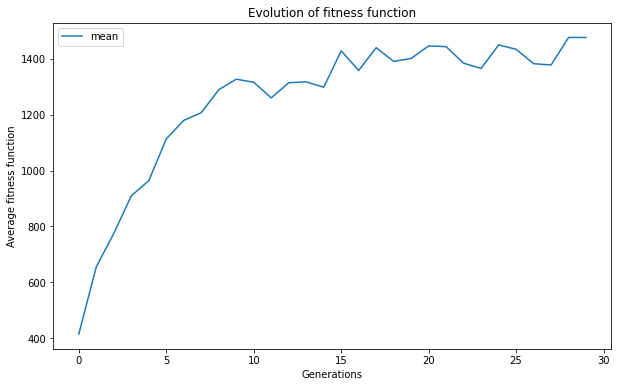

In [24]:
plot_fitness_functions(avg_fitness)

In [98]:
def extract_restults(
        population,
        max_fitness,
        df_stations
):
    best_gen = np.argmax(max_fitness)
    best_solution = population[-1][0]
    i=-1
    while type(best_solution) == int:
        best_solution = population[i-1][0]
    chosen_stations = pd.concat([df_stations.iloc[best_solution,:11],df_stations.iloc[best_solution,-2:]],axis=1)

    return chosen_stations

In [26]:
chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
)

chosen_stations_2030_per_reg['Region'] = region_name

In [96]:
chosen_stations_2030['Region'].unique()

array(['Bretagne', 'Hauts-de-France', 'Île-de-France',
       'Auvergne-Rhône-Alpes'], dtype=object)

In [97]:
list_regions = list(nb_stations_per_region['Region'].values)
list_regions.remove('Bretagne')
list_regions.remove('Hauts-de-France')
list_regions.remove('Île-de-France')
list_regions.remove('Auvergne-Rhône-Alpes')
list_regions

['Grand Est',
 'Nouvelle-Aquitaine',
 'Pays de la Loire',
 'Occitanie',
 'Centre-Val de Loire',
 'Bourgogne-Franche-Comté',
 'Normandie',
 "Provence-Alpes-Côte d'Azur"]

In [80]:
chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
)

In [90]:
chosen_stations_2030['Region'] = chosen_stations_2030['Region'].fillna('Auvergne-Rhône-Alpes')

In [99]:
for region_name in list_regions:

    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points,
        nb_stations_per_region,                                                          
        region_name=region_name,
        year = 2030,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2030_per_reg['Region'] = region_name

    chosen_stations_2030 = pd.concat([chosen_stations_2030,chosen_stations_2030_per_reg],axis=0)

chosen_stations_2030.to_csv('chosen_stations_2030.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

[ 559  531  829  844  180  138 1223  374 1242  483 1093  178 1306  912
  117  142  419 1118 1231  207  664  741 1020  298  683  811   83 1154
 1054  517  509  159  962  208]
[ 882  290 1307 1164   40  815 1291  894  516  313  284 1275  228   41
  513  484  497  752  634 1135  151  979  921  804 1085  358  269  735
  803   39  299  356  199  969]
[ 689  297  393  487  724  493  263  185  411  163  756  760 1218  470
  371  949  743  258  815 1289  747  301  933  335  957  758  100  227
  575   18 1228 1176   67  195]
[1130  176  637  270  515  755  716  177  695  527  533   92  180  620
  919 1266  911  778  816  322   26 1018  155  958  213 1263  900  316
  452   94  756  394  319  259]
[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  975  713  380    5  756  289  950 1214 1211  877 1282  316
  109  576   12  632  126  133]
[ 653  377  875 1057  459  677  359  696  781  768  953  962  886  127
 1260  342  764  706 1283   47  497  171  152  704 1152   8

  3%|▎         | 1/30 [00:12<06:08, 12.72s/it]

[ 141  540  321  710  630  471  156 1049 1171 1169  498 1284  922  245
 1208 1045  183  444  116  349  433  463  802    6  373  672 1054  232
 1017  786  837  437   76  860]
[ 438   74 1153  413  646   24  432   58  308  931  158  116   20  731
  629  194   71  165 1286  427 1121 1105   70  855   23   44  831   63
  870 1044  777  108  838  900]
[1227  991 1275 1127   75 1096   77  619  150 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335   18   66]
[ 846  770  424  353  212  665  201  697  321  418  821  912    8  467
 1153   71 1033  404  838  719 1048   40  553 1178  104  324 1102   37
  689  727  997  476 1205  487]
[ 846  770  424  353  212  665  201  697  321  418  821  912    8  467
 1153   71 1033  404  838  719 1048   40  553 1178  104  324 1102   37
  689  727  997  476 1205  487]
[ 961  557 1064  166  359 1069  801  583  673 1111    8  792  760   43
   77  390  870  840  565  996 1048   40  553 1178  104  32

  7%|▋         | 2/30 [00:25<05:56, 12.73s/it]

[1282 1132  294  218   75 1096   77  619  150 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335  397  182]
[ 438   74 1153  413  646   24  432   58  308  931  158  116   20  731
  629  194   71  165 1286  427 1121 1105   70  855   23   44  831   63
  870 1044  777  108  838  900]
[1227  991  424  353  212  665  201  697  321 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335   18   66]
[ 150   72  658  443 1008  909   11   92  101  433  593  163  634  166
  302  520  685  778  816  322  747  301  933  424  993   31 1123  346
  778  652  369  251  615  981]
[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  764  706 1283   47  497  171  152 1214 1211 1277  147 1285
   13  576   12  632  126  133]
[1282 1132  294  218   75 1096   77  619  150 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  18

 10%|█         | 3/30 [00:37<05:40, 12.61s/it]

[1227  991  424  353  212  665  201  697  321 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335   18   66]
[ 846  770  424  353  212  665  201  697  150 1295  109  279  411  990
   98 1063  469  674  610  978 1048 1105  526  813  653  180  538  112
  665  328  780  476 1205  487]
[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  764  706 1283   47  497  171  152 1214 1211 1277  147 1285
   13  576   12  632  126  133]
[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  764  706 1283   47  497  171  152 1214 1211 1277  147 1285
   13  576   12  632  126  133]
[1282 1132  294  218   75 1096   77  619  150 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335  397  182]
[   7  698 1153  413  646   24  432   58  308  931  158  581 1122  390
  413  386  766  651 1286  427 1121 1105  823  275 1214 123

 13%|█▎        | 4/30 [00:49<05:13, 12.05s/it]

[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  764  706 1283   47  497  171  152 1214 1211 1277  147 1285
   13  328  780  632  126  133]
[ 920  964  482 1067   87  480  865 1065  917  145   59  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335  397  182]
[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[1282 1132  294  218   75  306 1224  454   38  822  109  581 1122  390
  413  386  766  651  211  649  481  765  526  424  993   31 1123  112
  665  328  780  335  397  182]
[ 846  770  424  353  212  665  201  697  150 1295  109  279  411  990
   98 1063  469  674  610  978 1048 1105  526  813  653  180  538  112
  665  328  780  476 1205  487]
[1227  991  424  353  212  665   77  619  150 1295  109  581 1122  390
  413  386  766  651  211  649  481  765  526  813  653  18

 17%|█▋        | 5/30 [01:00<04:53, 11.72s/it]

[1282 1132  294  218   75 1096   77  619  625  145   59 1068   96  453
  621 1122  764  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335  397  182]
[ 920  964  482 1067   87  480  865 1065  917  145   59 1068   96  453
  621 1122  766  651  211  649  481  765  526  813  653  180  538  112
   13  576   12  632  126  133]
[1227  991  424  353  212  665  201  697  321 1295  109  279  411  990
   98 1063  469  674  610  978 1048 1105  526  813  653  180  538  112
  665  328  780  335   18   66]
[ 846  770  424  353  212  665  201  619  150 1295  109 1068   96  453
  621 1122  764  706  211  649  481  765  526  813  653  180  538  112
  665  328  780  476 1205  487]
[ 846  770  424  353  212  665  201  619  150 1295  109 1068   96  453
  621 1122  764  706  211  649  481  765  526  813  653  180  538  112
  665  328  780  476 1205  487]
[1282 1132  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  18

 20%|██        | 6/30 [01:16<05:15, 13.14s/it]

[ 920  964  482 1067   87  480  865 1065  625  145   59 1068   96  453
  621 1122  764  651  211  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  201  697  150 1295  109  279  411  990
   98 1063  469  674  610   47  497  171  152  813  653  180  538  112
   13  576   12  632  126  133]
[ 846  770  424  353  212 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  476 1205  487]
[ 920  964  482 1067   87  480  865 1065  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865 1065  917  145   59  581 1122  453
  621 1122  764  706 1283   47  497  171  152  813  653  18

 23%|██▎       | 7/30 [01:29<05:02, 13.13s/it]

[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865 1065  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328   12  632  126  133]
[ 846  770  424  353  212  665  201  619  150 1295  109 1068   96  453
  621 1122  764  706  211  649  481  765  526  813  653  18

 27%|██▋       | 8/30 [01:43<04:55, 13.43s/it]

[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865 1065  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865 1065  150 1295  109 1068   96  453
  621 1122  764  706  211   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  201  697  150 1295  109  279  411  990
   98 1063  469  674  610   47  497  171  152  813  653  180  538  112
  665  328   12  632  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 30%|███       | 9/30 [01:56<04:39, 13.32s/it]

[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  469  674 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75 1096   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  526  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  18

 33%|███▎      | 10/30 [02:05<04:03, 12.17s/it]

[ 920  964  482 1067   87  480  865  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 37%|███▋      | 11/30 [02:15<03:36, 11.39s/it]

[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75 1096   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75 1096   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480  865  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 40%|████      | 12/30 [02:27<03:26, 11.49s/it]

[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 43%|████▎     | 13/30 [02:44<03:46, 13.31s/it]

[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  294  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 47%|████▋     | 14/30 [02:56<03:23, 12.74s/it]

[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75 1096   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  294  218   75  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 50%|█████     | 15/30 [03:08<03:06, 12.46s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482 1067   87  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  294  218   75  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  18

 53%|█████▎    | 16/30 [03:20<02:55, 12.55s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283   47  497  171  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 57%|█████▋    | 17/30 [03:30<02:31, 11.69s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109 1068   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  335  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 60%|██████    | 18/30 [03:47<02:41, 13.43s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 63%|██████▎   | 19/30 [03:59<02:21, 12.87s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 67%|██████▋   | 20/30 [04:17<02:25, 14.52s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 70%|███████   | 21/30 [04:30<02:04, 13.86s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 73%|███████▎  | 22/30 [04:39<01:39, 12.38s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 77%|███████▋  | 23/30 [04:48<01:19, 11.37s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 80%|████████  | 24/30 [04:57<01:03, 10.65s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 83%|████████▎ | 25/30 [05:06<00:50, 10.15s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 87%|████████▋ | 26/30 [05:15<00:39,  9.85s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 90%|█████████ | 27/30 [05:25<00:29,  9.95s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 93%|█████████▎| 28/30 [05:38<00:21, 10.88s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

 97%|█████████▋| 29/30 [06:21<00:20, 20.47s/it]

[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  180  538  112
  665  328  780  632  126  133]
[ 920  964  482  218   75  480   77  619  150 1295  109  581   96  453
  621 1122  764  706 1283  649  481  765  152  813  653  18

  0%|          | 0/30 [00:00<?, ?it/s]

[ 817  913  661   85  506  598  604  421  326   92 1021   95  352  107
 1367   44  223 1170 1114   43  514   51 1156  545 1385  209  685  882
 1427 1520  563  350  109 1269]
[1185 1311 1407  165  435  345 1026  798  120  228 1488  334 1107  909
 1275  975   26  333  822 1020 1318  830  985  376  312 1239 1182  656
  826 1180 1444   71 1232  176]
[ 194  153 1331 1404  184 1071 1432 1173   20  439 1141 1447 1167  789
  465 1515  772  531  219 1365  740  459 1491  275  791 1354   14  936
 1461 1274 1437  875  428  823]
[ 435  466   79  135  270  241   66  454  247 1279   56  745  399  426
  704  927  865  851 1347  330  771 1358  640  963  731 1098 1511 1319
  159  744  801 1309  329  796]
[ 644 1293 1210 1020 1282 1032 1418 1253  817  159  262 1477 1137  509
  565  152  718  257 1019    6  572  773 1438  734  358  500   45  521
   19 1530  703  969  469  281]
[ 568 1335  302  779 1486  315  407  394  453  251 1152 1485 1247  563
  348  217  746  770 1018 1023 1176  163  643  138  783  39

  3%|▎         | 1/30 [00:13<06:22, 13.17s/it]

[1231  961   51  496 1370  454  586  223 1523  418  796    1  181 1475
 1259  553  169  492  853  488  219  434 1296 1282 1110  555 1035  508
 1515  899  451  138  254 1292]
[1020  335   79  105  575   88   35  798  316 1428  599  782 1357 1412
  182 1334  858  209 1265  469  677  774  678 1051  966  999  259 1043
  556  226  681 1137  396  986]
[  24   20  859  347  406  978  256   62  319  418  796  669  948  298
 1336 1247 1042  937  648  622  468 1286  402  412 1505  179  365 1333
  410  769  597  276  182 1441]
[1337  593 1513  433  270  241   66  454  247 1279   56  745  399  426
  704  927  865  281  410  543   83 1299  352  652  645 1118  169 1391
  737  640  191  475  904  335]
[ 644 1293 1210 1020 1282 1032 1418 1253  817  159  262 1477 1137  509
  565  152  718  257 1019    6  572  773 1438  734  358  500   45  521
   19 1530  703  969  469  281]
[ 644 1293 1210 1020 1282 1032 1418 1253  817  159  262 1477 1137  509
  565  152  718  257 1019    6  572  773 1438  734  358  50

  7%|▋         | 2/30 [00:25<05:47, 12.41s/it]

[ 568 1335  302  779 1486  315  407  394  453  251 1152 1485 1247  563
  348  217  746  770 1018 1023 1176  163  643  138  783  390 1316 1365
 1162 1431 1318  923 1309 1313]
[1502   30  659  928  873 1462  197  478  296 1032  897  138  275 1285
 1207 1413 1233 1203  860  780  398  555  190  857 1039  694   45  400
 1435  990  483 1429  771 1163]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247  223 1170 1114   43  514   51 1156  412 1505  179  365 1333
  410  769  597  276  182 1441]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  468 1286  402  412 1505  179  365 1333
  410  769  597  276  182 1441]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  468 1286  402  412 1505  179  430  241
  410  769  597  276  182 1441]
[ 644 1293 1210 1020 1282 1032 1418 1253  817  159 1152 1485 1247  563
  348  217  746  257 1019    6  572  773 1438  734  358  50

 10%|█         | 3/30 [00:35<05:12, 11.56s/it]

[1502   30  659  928  873 1462  197  478  296 1032  897  138  275 1285
 1207 1413 1233 1203  860  780  398  555  190  857 1039  694   45  400
 1435  769  597 1429  771 1163]
[1020   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  468  774  678  412 1505  179  259 1043
  556  226  681 1137  396  986]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  468 1286  402  412 1505  179  430  241
  410  769  597  276  182 1441]
[1502   30  659  928  873 1462  197  478  296 1032  897  138  275 1285
 1207 1413 1233 1203  860  780  398  555  190  857 1039  694   45  400
 1435  769  597 1429  771 1163]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  468 1286  402  412 1505  179  430  241
  410  769  597  276  182 1441]
[1337  593 1513  433  270  241   66  454  247 1279   56  745  399  426
  704  217  746  257 1019    6  572  773  402  412 1505  17

 13%|█▎        | 4/30 [00:45<04:41, 10.83s/it]

[1020  335   79  105  575  978  256   62   20  439 1141 1447 1167  298
 1336 1515  772  531  219  469  468  774  678  412 1505  179  259 1043
  556  226  681 1137  396  986]
[1502   30  659  928  873 1462  197  478  296 1032  897  138  275 1285
 1207 1413 1233 1203  860  780  398  555  190  857 1039  694   45  400
 1435  990  483 1429  771 1163]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  468 1286  402  412 1505  179  430  241
  410  769  597  276  182 1441]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
  518  737 1418  151 1164   33  280 1192   43  810 1201 1173  430  241
  410  769  597  276  182 1441]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
  518  737 1418  151 1164   33  280 1192   43  810 1201 1173  430 1333
  410  769  597  276  182 1441]
[  24   20  859  347  406  978  256   62  319  736 1504  669  948  298
 1336 1247 1042  937  648  622  398  555  190  857 1039  69

In [75]:
chosen_stations_2030

,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,TMJA_PL,percentage_traffic,Region,Quantity_sold_per_day(in kg),Revenues_day
296,296,670842.4759115779,6859116.178390036,A0004,POINT (670842.476 6859116.178),1.0,0 1405.055282 dtype: float64,5.0,0 0.0 dtype: float64,489209.44,0.039490,Bretagne,NaN,NaN
19,19,652120.8648179206,6866968.606225524,75000C01,POINT (652120.865 6866968.606),1.0,0 354.947188 dtype: float64,5.0,0 0.0 dtype: float64,0.00,0.000000,Bretagne,NaN,NaN
538,538,1048155.0540478148,6845895.819063297,A0004,POINT (1048155.054 6845895.819),1.0,0 1337.099909 dtype: float64,5.0,0 0.0 dtype: float64,489209.44,0.039490,Bretagne,NaN,NaN
8,8,847862.0769520273,6520701.477917263,69D0383,POINT (847862.077 6520701.478),1.0,0 172.756327 dtype: float64,5.0,0 0.0 dtype: float64,0.00,0.000000,Bretagne,NaN,NaN
611,611,773061.0275846705,6794953.429897669,A0005,POINT (773061.028 6794953.430),1.0,0 2893.642493 dtype: float64,5.0,0 2603.828671 dtype: float64,52949.71,0.004274,Bretagne,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,574,712465.3610683695,6806227.617006706,A0005,POINT (712465.361 6806227.617),1.0,0 14413.817413 dtype: float64,5.0,0 10804.579573 dtype: float64,52949.71,0.004274,Île-de-France,38.572421,270.006949
505,505,1002574.7736638645,6868786.85773668,A0004,POINT (1002574.774 6868786.858),1.0,0 21962.99807 dtype: float64,5.0,0 11893.683771 dtype: float64,489209.44,0.039490,Île-de-France,155.993656,1091.955592
177,177,700064.9683,7044327.5911,A0001,POINT (700064.968 7044327.591),1.0,0 314.438543 dtype: float64,5.0,0 0.0 dtype: float64,333120.37,0.026890,Île-de-France,210.199304,1471.395128
330,330,720543.0168360922,6883044.05949596,A0004,POINT (720543.017 6883044.059),1.0,0 8182.322943 dtype: float64,5.0,0 5381.325792 dtype: float64,489209.44,0.039490,Île-de-France,155.993656,1091.955592


In [59]:
chosen_stations_2030_per_reg = sales(chosen_stations_2030_per_reg, 2030)
chosen_stations_2030_per_reg = station_type(chosen_stations_2030_per_reg)

[104.68942068665035,
 148.71325512179317,
 265.40142907862867,
 300.31429468421334,
 392.05690715679975,
 523.6260467979054,
 523.6260467979054,
 541.6647048164344,
 541.6647048164344,
 618.9825967847526,
 628.4830865676704,
 693.8942548465393,
 695.5500290142843,
 740.7320579397809,
 740.7320579397809,
 759.6633352333575,
 811.405515750517,
 838.8409174477548,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494,
 882.5093645790494]

In [25]:
finance_chosen_stations_2030 = financial_summary(chosen_stations_2030)

In [26]:
finance_chosen_stations_2030

station_type,large,not profitable
CAPEX,-2.010128e+09,0.0
EBIT,4.174722e+08,0.0
EBITDA,7.709022e+08,0.0
Opex,7.497000e+07,0.0
Revenues,8.458722e+08,0.0
depreciation,3.534300e+08,0.0
Total,4.525189e+08,0.0


## Part 2.2

- done !

## Part 3.3

- add distance to all total stations and add it to fitness function to maximise it
- focus on a niche total is not very present and where traffic is quite high --> conventional for production but more risky for profitability
